In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris-segmentation/results/results/S1209R04.png
/kaggle/input/iris-segmentation/results/results/S1104L04.png
/kaggle/input/iris-segmentation/results/results/S1071R06.png
/kaggle/input/iris-segmentation/results/results/S1083L07.png
/kaggle/input/iris-segmentation/results/results/S1003R07.png
/kaggle/input/iris-segmentation/results/results/S1162R06.png
/kaggle/input/iris-segmentation/results/results/S1088R06.png
/kaggle/input/iris-segmentation/results/results/S1088R07.png
/kaggle/input/iris-segmentation/results/results/S1084R01.png
/kaggle/input/iris-segmentation/results/results/S1142R04.png
/kaggle/input/iris-segmentation/results/results/S1068L03.png
/kaggle/input/iris-segmentation/results/results/S1218R04.png
/kaggle/input/iris-segmentation/results/results/S1160R06.png
/kaggle/input/iris-segmentation/results/results/S1029R10.png
/kaggle/input/iris-segmentation/results/results/S1162L09.png
/kaggle/input/iris-segmentation/results/results/S1093R10.png
/kaggle/input/iris-segme

In [2]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations
!pip install torchsummary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=b6f9afe2a83f60e853eb9934bd3803ddd6524a2750e4c92c9c6ecf2a1c1ad8af
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=beca12dec296265a82d83a2622372925bbc0bad7dcfa8b64c439d7e05cbeb329
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob

In [4]:
print(A.__version__)

1.4.0


In [5]:
class IrisDataset(Dataset):
    def __init__(self, root_dir, ROI_input, results, transform=None):
        self.root_dir = root_dir
        self.ROI_input = ROI_input
        self.results = results
        self.transform = transform
        self.img_path_lst = []
        # Lấy danh sách các tệp hình ảnh từ thư mục ROI_input
        img_files = [f for f in os.listdir(self.ROI_input) if f.endswith(".jpg")]
        for filename in img_files:
            self.img_path_lst.append(filename)  # Thêm tên file vào danh sách

    def __len__(self):
        return len(self.img_path_lst)

    def __getitem__(self, idx):
        # Xây dựng đường dẫn đầy đủ đến hình ảnh và mặt nạ
        image_path = os.path.join(self.ROI_input, self.img_path_lst[idx])
        mask_path = os.path.join(self.results, self.img_path_lst[idx].replace(".jpg", ".png"))

        # Đọc hình ảnh và mặt nạ từ đường dẫn
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:  # Kiểm tra xem mask có bị None hay không
          mask = np.zeros_like(image[..., 0])  # Tạo mặt nạ trống
        else:
          mask = mask.astype('uint8')  # Chuyển đổi kiểu dữ liệu sang uint8

        # Chuyển các giá trị mặt nạ 255 thành 1
        mask[mask >= 200] = 1

        # Áp dụng biến đổi nếu có
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']
            return transformed_image, transformed_mask
        else:
            return image, mask

In [6]:
trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

In [7]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [8]:
 train_dataset = IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/train", "/kaggle/input/iris-segmentation/results/results", train_transform)
 test_dataset =  IrisDataset("/kaggle/input/iris-segmentation", "/kaggle/input/iris-segmentation/data_iris/data_iris/test", "/kaggle/input/iris-segmentation/results/results", test_trainsform)
# image, mask = train_dataset.__getitem__(10)
# plt.subplot(1, 2, 1)
# plt.imshow(unorm(image).permute(1, 2, 0))
# plt.subplot(1, 2, 2)
# plt.imshow(mask)
# plt.show

In [9]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

# model = UNet(1)
# x = torch.rand(4, 3, trainsize, trainsize)
# print("Input shape =", x.shape)
# y = model(x).squeeze()
# print("Output shape = ", y.shape)
# # y true (4, 384, 384)
# # y hat.squeeze() (4, 1, 384, 384) -> (4, 384, 384)

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [12]:
from torchsummary import summary

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = UNet(1).to(device)
summary(model, input_size=(3, 384, 384))

#loss
criterion = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 100

#metrics
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 4
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           1,792
              ReLU-2         [-1, 64, 384, 384]               0
            Conv2d-3         [-1, 64, 384, 384]          36,928
              ReLU-4         [-1, 64, 384, 384]               0
         MaxPool2d-5         [-1, 64, 192, 192]               0
            Conv2d-6        [-1, 128, 192, 192]          73,856
              ReLU-7        [-1, 128, 192, 192]               0
            Conv2d-8        [-1, 128, 192, 192]         147,584
              ReLU-9        [-1, 128, 192, 192]               0
        MaxPool2d-10          [-1, 128, 96, 96]               0
           Conv2d-11          [-1, 256, 96, 96]         295,168
             ReLU-12          [-1, 256, 96, 96]               0
           Conv2d-13          [-1, 256, 96, 96]         590,080
             ReLU-14   

In [13]:
best_iou = 0.0
best_dice = 0.0
best_epoch = 0

# Kiểm tra xem có nhiều hơn một GPU hay không và bọc mô hình trong DataParallel nếu có
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()  # -> logit (-vc, +vc)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long()  # -> mask (0, 1)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print(f"EP {ep}, train loss = {train_loss_meter.avg}, accuracy = {acc_meter.avg}, IoU = {iou_meter.avg}, dice = {dice_meter.avg}")

    # Kiểm tra xem epoch hiện tại có chỉ số IoU và Dice tốt nhất không
    if iou_meter.avg > best_iou or dice_meter.avg > best_dice:
        best_iou = max(iou_meter.avg, best_iou)
        best_dice = max(dice_meter.avg, best_dice)
        best_epoch = ep
        # Lưu mô hình nếu nó là tốt nhất cho đến thời điểm hiện tại
        model_to_save = model.module if isinstance(model, nn.DataParallel) else model
        torch.save(model_to_save.state_dict(), f"best_model_epoch_{best_epoch}.pth")
        print(f"Saved new best model at epoch {ep} with IoU: {best_iou}, Dice: {best_dice}")

print(f"Best model was saved at epoch {best_epoch} with IoU: {best_iou}, Dice: {best_dice}")

100%|██████████| 264/264 [02:20<00:00,  1.88it/s]


EP 1, train loss = 0.31378611537718004, accuracy = 0.8465750559005158, IoU = 0.49606915033511656, dice = 0.7355121061969301
Saved new best model at epoch 1 with IoU: 0.49606915033511656, Dice: 0.7355121061969301


100%|██████████| 264/264 [02:20<00:00,  1.89it/s]


EP 2, train loss = 0.08309258372863963, accuracy = 0.9683011846026615, IoU = 0.893272034696655, dice = 0.9606524117757519
Saved new best model at epoch 2 with IoU: 0.893272034696655, Dice: 0.9606524117757519


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 3, train loss = 0.05690893050163023, accuracy = 0.9783321676715728, IoU = 0.9255573057359264, dice = 0.9730995947767254
Saved new best model at epoch 3 with IoU: 0.9255573057359264, Dice: 0.9730995947767254


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 4, train loss = 0.05111463515678212, accuracy = 0.9802701036663164, IoU = 0.9320317880026077, dice = 0.9755184661731322
Saved new best model at epoch 4 with IoU: 0.9320317880026077, Dice: 0.9755184661731322


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 5, train loss = 0.048683407707617, accuracy = 0.9811139343133235, IoU = 0.9348203111192533, dice = 0.9765599298748617
Saved new best model at epoch 5 with IoU: 0.9348203111192533, Dice: 0.9765599298748617


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 6, train loss = 0.04684969453420313, accuracy = 0.9818364109214841, IoU = 0.9371956810779318, dice = 0.9774472019025452
Saved new best model at epoch 6 with IoU: 0.9371956810779318, Dice: 0.9774472019025452


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 7, train loss = 0.044469491771265045, accuracy = 0.9828285781889305, IoU = 0.9405511381277776, dice = 0.9786906476491316
Saved new best model at epoch 7 with IoU: 0.9405511381277776, Dice: 0.9786906476491316


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 8, train loss = 0.044081082889205814, accuracy = 0.983175559785832, IoU = 0.9416767364434997, dice = 0.9791036570547201
Saved new best model at epoch 8 with IoU: 0.9416767364434997, Dice: 0.9791036570547201


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 9, train loss = 0.04148047485970229, accuracy = 0.9836447509235404, IoU = 0.9432933069270747, dice = 0.9797000028829195
Saved new best model at epoch 9 with IoU: 0.9432933069270747, Dice: 0.9797000028829195


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 10, train loss = 0.041502650714067627, accuracy = 0.9838116395179416, IoU = 0.9439096320738602, dice = 0.9799202058527908
Saved new best model at epoch 10 with IoU: 0.9439096320738602, Dice: 0.9799202058527908


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 11, train loss = 0.03979935172584749, accuracy = 0.9843044521912678, IoU = 0.9455405920461187, dice = 0.9805266787024105
Saved new best model at epoch 11 with IoU: 0.9455405920461187, Dice: 0.9805266787024105


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 12, train loss = 0.04020338653952618, accuracy = 0.9840231076363595, IoU = 0.9445624495140742, dice = 0.9801682395545989


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 13, train loss = 0.03955613594127561, accuracy = 0.9844694516464247, IoU = 0.9461008777428397, dice = 0.9807314033526398
Saved new best model at epoch 13 with IoU: 0.9461008777428397, Dice: 0.9807314033526398


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 14, train loss = 0.03876803599057659, accuracy = 0.9845830430568282, IoU = 0.9464077782133272, dice = 0.9808496285434918
Saved new best model at epoch 14 with IoU: 0.9464077782133272, Dice: 0.9808496285434918


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 15, train loss = 0.03892820631728226, accuracy = 0.9846498678938488, IoU = 0.946701307111266, dice = 0.9809513009476707
Saved new best model at epoch 15 with IoU: 0.946701307111266, Dice: 0.9809513009476707


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 16, train loss = 0.03815897837620533, accuracy = 0.9847428681049673, IoU = 0.9470490624375316, dice = 0.9810766284786999
Saved new best model at epoch 16 with IoU: 0.9470490624375316, Dice: 0.9810766284786999


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 17, train loss = 0.03801179973433321, accuracy = 0.9848314615309351, IoU = 0.9473969180850874, dice = 0.9811977111863457
Saved new best model at epoch 17 with IoU: 0.9473969180850874, Dice: 0.9811977111863457


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 18, train loss = 0.04154891985162838, accuracy = 0.9837347137860148, IoU = 0.9436808218313576, dice = 0.979829196007021


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 19, train loss = 0.03881151587181005, accuracy = 0.984710219123558, IoU = 0.9468442858735796, dice = 0.9810060756934889


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 20, train loss = 0.038035179988482874, accuracy = 0.9849206873090263, IoU = 0.9476491838297763, dice = 0.9812960767203083
Saved new best model at epoch 20 with IoU: 0.9476491838297763, Dice: 0.9812960767203083


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 21, train loss = 0.036773869078571025, accuracy = 0.9853052777402541, IoU = 0.9490165314592944, dice = 0.9817875676860846
Saved new best model at epoch 21 with IoU: 0.9490165314592944, Dice: 0.9817875676860846


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 22, train loss = 0.036818072938517556, accuracy = 0.9854865471145008, IoU = 0.9496607168575845, dice = 0.98202098546942
Saved new best model at epoch 22 with IoU: 0.9496607168575845, Dice: 0.98202098546942


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 23, train loss = 0.03727404298914678, accuracy = 0.985215532485629, IoU = 0.9486647145345496, dice = 0.9816634573565488


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 24, train loss = 0.036401733847960575, accuracy = 0.9854850712492073, IoU = 0.9495670065934111, dice = 0.9819970974659784


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 25, train loss = 0.03649289847706821, accuracy = 0.9854760199389376, IoU = 0.9495607968525823, dice = 0.9819885460656327


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 26, train loss = 0.03508821324899482, accuracy = 0.9857606488568055, IoU = 0.9504896670410258, dice = 0.9823378161642086
Saved new best model at epoch 26 with IoU: 0.9504896670410258, Dice: 0.9823378161642086


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 27, train loss = 0.03506491317694735, accuracy = 0.9859187989804957, IoU = 0.9511194928095056, dice = 0.9825564683953997
Saved new best model at epoch 27 with IoU: 0.9511194928095056, Dice: 0.9825564683953997


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 28, train loss = 0.03633664619439128, accuracy = 0.9856290691717752, IoU = 0.9500336330348672, dice = 0.9821692019757555


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 29, train loss = 0.03466361616534911, accuracy = 0.9860530107704467, IoU = 0.9514824260570519, dice = 0.9826990389733432
Saved new best model at epoch 29 with IoU: 0.9514824260570519, Dice: 0.9826990389733432


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 30, train loss = 0.03491641673307152, accuracy = 0.9859833385957939, IoU = 0.9512639977674104, dice = 0.9826173350299785


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 31, train loss = 0.034406454272327885, accuracy = 0.9860965512282934, IoU = 0.9517160275176988, dice = 0.9827741773576393
Saved new best model at epoch 31 with IoU: 0.9517160275176988, Dice: 0.9827741773576393


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 32, train loss = 0.03401368036442056, accuracy = 0.9863398174633338, IoU = 0.9524608410513152, dice = 0.9830552842856811
Saved new best model at epoch 32 with IoU: 0.9524608410513152, Dice: 0.9830552842856811


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 33, train loss = 0.03396070483485254, accuracy = 0.9863542459721357, IoU = 0.9525425560786557, dice = 0.9830815176809987
Saved new best model at epoch 33 with IoU: 0.9525425560786557, Dice: 0.9830815176809987


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 34, train loss = 0.033288237803122574, accuracy = 0.9866230957195926, IoU = 0.9534249155299713, dice = 0.9834069447906465
Saved new best model at epoch 34 with IoU: 0.9534249155299713, Dice: 0.9834069447906465


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 35, train loss = 0.03323855401994042, accuracy = 0.986524122263494, IoU = 0.9530999165106091, dice = 0.9832875414184193


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 36, train loss = 0.032253249320404805, accuracy = 0.9868110845844479, IoU = 0.9539843051211884, dice = 0.9836200903217526
Saved new best model at epoch 36 with IoU: 0.9539843051211884, Dice: 0.9836200903217526


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 37, train loss = 0.03275127489070286, accuracy = 0.9867668795404669, IoU = 0.95394677376159, dice = 0.9835939745522994


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 38, train loss = 0.031682440141601174, accuracy = 0.9870913180273443, IoU = 0.955034167196538, dice = 0.9839921210250999
Saved new best model at epoch 38 with IoU: 0.955034167196538, Dice: 0.9839921210250999


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 39, train loss = 0.03232641205672295, accuracy = 0.986940555712756, IoU = 0.9545206810989235, dice = 0.9838066659797075


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 40, train loss = 0.030672491847959824, accuracy = 0.9873755556130093, IoU = 0.9559951389537138, dice = 0.9843457323097866
Saved new best model at epoch 40 with IoU: 0.9559951389537138, Dice: 0.9843457323097866


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 41, train loss = 0.03022638799541363, accuracy = 0.9875682625191488, IoU = 0.9565899307632808, dice = 0.9845693769672111
Saved new best model at epoch 41 with IoU: 0.9565899307632808, Dice: 0.9845693769672111


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 42, train loss = 0.030025360112624556, accuracy = 0.9875905252498286, IoU = 0.9566848161550808, dice = 0.9846026868023954
Saved new best model at epoch 42 with IoU: 0.9566848161550808, Dice: 0.9846026868023954


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 43, train loss = 0.029212679236816273, accuracy = 0.987873304500978, IoU = 0.9576817046306617, dice = 0.9849613929835397
Saved new best model at epoch 43 with IoU: 0.9576817046306617, Dice: 0.9849613929835397


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 44, train loss = 0.029795420403809655, accuracy = 0.9877603451033924, IoU = 0.957292071216699, dice = 0.9848197125167051


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 45, train loss = 0.028564016583889892, accuracy = 0.9881408797043324, IoU = 0.9586418932710246, dice = 0.9853045323994399
Saved new best model at epoch 45 with IoU: 0.9586418932710246, Dice: 0.9853045323994399


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 46, train loss = 0.027655397041699014, accuracy = 0.988377992410135, IoU = 0.9593976359439755, dice = 0.9855859609889803
Saved new best model at epoch 46 with IoU: 0.9593976359439755, Dice: 0.9855859609889803


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 47, train loss = 0.027427972384518193, accuracy = 0.9886215736336681, IoU = 0.960195328524262, dice = 0.9858786641307302
Saved new best model at epoch 47 with IoU: 0.960195328524262, Dice: 0.9858786641307302


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 48, train loss = 0.027203625527544538, accuracy = 0.9886195285270517, IoU = 0.9601662465471923, dice = 0.985872274558051


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 49, train loss = 0.02641832205048096, accuracy = 0.9888767922399618, IoU = 0.9610715667934526, dice = 0.9861973007218435
Saved new best model at epoch 49 with IoU: 0.9610715667934526, Dice: 0.9861973007218435


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 50, train loss = 0.0250970848272263, accuracy = 0.9894025087130364, IoU = 0.9629132264705491, dice = 0.9868592254577144
Saved new best model at epoch 50 with IoU: 0.9629132264705491, Dice: 0.9868592254577144


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 51, train loss = 0.024438257793943614, accuracy = 0.989539375002063, IoU = 0.9633488545381593, dice = 0.9870218053262193
Saved new best model at epoch 51 with IoU: 0.9633488545381593, Dice: 0.9870218053262193


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 52, train loss = 0.023987146101510277, accuracy = 0.9898146016547983, IoU = 0.964331729927823, dice = 0.9873719368080487
Saved new best model at epoch 52 with IoU: 0.964331729927823, Dice: 0.9873719368080487


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 53, train loss = 0.023320723236653337, accuracy = 0.9900450731364328, IoU = 0.9650923795220522, dice = 0.9876513411017025
Saved new best model at epoch 53 with IoU: 0.9650923795220522, Dice: 0.9876513411017025


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 54, train loss = 0.023133095530563332, accuracy = 0.9900736858541644, IoU = 0.9652303020687212, dice = 0.9876929306667263
Saved new best model at epoch 54 with IoU: 0.9652303020687212, Dice: 0.9876929306667263


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 55, train loss = 0.022004881813641516, accuracy = 0.9905166287802202, IoU = 0.9667202608635123, dice = 0.9882350604719636
Saved new best model at epoch 55 with IoU: 0.9667202608635123, Dice: 0.9882350604719636


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 56, train loss = 0.02218445088622466, accuracy = 0.9905187936616351, IoU = 0.9667351170101925, dice = 0.9882406577665847
Saved new best model at epoch 56 with IoU: 0.9667351170101925, Dice: 0.9882406577665847


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 57, train loss = 0.02174603782127659, accuracy = 0.9907211267744568, IoU = 0.9674279697705944, dice = 0.9884906633981492
Saved new best model at epoch 57 with IoU: 0.9674279697705944, Dice: 0.9884906633981492


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 58, train loss = 0.02030686179504675, accuracy = 0.9911793660393702, IoU = 0.9690221427061526, dice = 0.9890616464886313
Saved new best model at epoch 58 with IoU: 0.9690221427061526, Dice: 0.9890616464886313


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 59, train loss = 0.01939510460059376, accuracy = 0.9915681627262701, IoU = 0.9703517604824261, dice = 0.9895409838750647
Saved new best model at epoch 59 with IoU: 0.9703517604824261, Dice: 0.9895409838750647


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 60, train loss = 0.019278343915373822, accuracy = 0.9916290705299016, IoU = 0.9705489505174264, dice = 0.9896123819830748
Saved new best model at epoch 60 with IoU: 0.9705489505174264, Dice: 0.9896123819830748


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 61, train loss = 0.018312101946892728, accuracy = 0.9920392419853066, IoU = 0.9719810321842244, dice = 0.9901256134885538
Saved new best model at epoch 61 with IoU: 0.9719810321842244, Dice: 0.9901256134885538


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 62, train loss = 0.017886203666000258, accuracy = 0.9921925676389256, IoU = 0.9725096122815894, dice = 0.9903131619350282
Saved new best model at epoch 62 with IoU: 0.9725096122815894, Dice: 0.9903131619350282


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 63, train loss = 0.017411272488605137, accuracy = 0.9924354631262893, IoU = 0.9733574989850878, dice = 0.9906152615737192
Saved new best model at epoch 63 with IoU: 0.9733574989850878, Dice: 0.9906152615737192


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 64, train loss = 0.016743875166977378, accuracy = 0.9926747443327641, IoU = 0.9741876439758678, dice = 0.9909131203475894
Saved new best model at epoch 64 with IoU: 0.9741876439758678, Dice: 0.9909131203475894


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 65, train loss = 0.01605642970608975, accuracy = 0.9929868797197288, IoU = 0.9752861808780475, dice = 0.9913030702203682
Saved new best model at epoch 65 with IoU: 0.9752861808780475, Dice: 0.9913030702203682


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 66, train loss = 0.015389963668157864, accuracy = 0.993267675391637, IoU = 0.9762367878738345, dice = 0.9916452869518432
Saved new best model at epoch 66 with IoU: 0.9762367878738345, Dice: 0.9916452869518432


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 67, train loss = 0.015300043878027112, accuracy = 0.9933184852410086, IoU = 0.9764362010376729, dice = 0.9917136815286451
Saved new best model at epoch 67 with IoU: 0.9764362010376729, Dice: 0.9917136815286451


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 68, train loss = 0.014740070690395598, accuracy = 0.9935441271629912, IoU = 0.9772287878637296, dice = 0.9919946882484986
Saved new best model at epoch 68 with IoU: 0.9772287878637296, Dice: 0.9919946882484986


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 69, train loss = 0.014637098069774585, accuracy = 0.9936303736136579, IoU = 0.9774961292856784, dice = 0.9920938480963517
Saved new best model at epoch 69 with IoU: 0.9774961292856784, Dice: 0.9920938480963517


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 70, train loss = 0.014440833057225655, accuracy = 0.9937447913457592, IoU = 0.9779167202437399, dice = 0.9922402773681582
Saved new best model at epoch 70 with IoU: 0.9779167202437399, Dice: 0.9922402773681582


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 71, train loss = 0.014073770000215839, accuracy = 0.9938563160471039, IoU = 0.9783066910403503, dice = 0.9923793688218553
Saved new best model at epoch 71 with IoU: 0.9783066910403503, Dice: 0.9923793688218553


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 72, train loss = 0.013417958267796537, accuracy = 0.9941552574313343, IoU = 0.9793480773804536, dice = 0.992749515023132
Saved new best model at epoch 72 with IoU: 0.9793480773804536, Dice: 0.992749515023132


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 73, train loss = 0.012972502251715881, accuracy = 0.9943345213976937, IoU = 0.9799784587049394, dice = 0.9929720509436822
Saved new best model at epoch 73 with IoU: 0.9799784587049394, Dice: 0.9929720509436822


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 74, train loss = 0.01331104295225761, accuracy = 0.994237480964335, IoU = 0.9796156781448133, dice = 0.9928465941373039


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 75, train loss = 0.012427604880954441, accuracy = 0.9945780650714316, IoU = 0.9808182731072862, dice = 0.9932719950884071
Saved new best model at epoch 75 with IoU: 0.9808182731072862, Dice: 0.9932719950884071


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 76, train loss = 0.012339547128050785, accuracy = 0.994650042599926, IoU = 0.9810792399990943, dice = 0.9933631313819813
Saved new best model at epoch 76 with IoU: 0.9810792399990943, Dice: 0.9933631313819813


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 77, train loss = 0.012709738564742924, accuracy = 0.994476538794769, IoU = 0.9804603612400323, dice = 0.993144918551255


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 78, train loss = 0.011644038626220805, accuracy = 0.9949145648465889, IoU = 0.9820174431212713, dice = 0.9936936806456188
Saved new best model at epoch 78 with IoU: 0.9820174431212713, Dice: 0.9936936806456188


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 79, train loss = 0.011460889220958757, accuracy = 0.9950057288501023, IoU = 0.9823357686824545, dice = 0.993806443246085
Saved new best model at epoch 79 with IoU: 0.9823357686824545, Dice: 0.993806443246085


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 80, train loss = 0.01212241710737998, accuracy = 0.9947685886605641, IoU = 0.981499251310468, dice = 0.9935108063569331


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 81, train loss = 0.010951970852345963, accuracy = 0.9952182816147126, IoU = 0.983077686131566, dice = 0.9940694608995991
Saved new best model at epoch 81 with IoU: 0.983077686131566, Dice: 0.9940694608995991


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 82, train loss = 0.011753583137843708, accuracy = 0.9949625360671664, IoU = 0.9821655423410477, dice = 0.9937477984962246


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 83, train loss = 0.011174021810081132, accuracy = 0.9951616323197815, IoU = 0.982876924341951, dice = 0.9939986060194996


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 84, train loss = 0.010511526712472683, accuracy = 0.9954304411243895, IoU = 0.9838170109482824, dice = 0.9943310167124421
Saved new best model at epoch 84 with IoU: 0.9838170109482824, Dice: 0.9943310167124421


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 85, train loss = 0.010177989483261356, accuracy = 0.9955611260611373, IoU = 0.9842766207807204, dice = 0.9944934562216221
Saved new best model at epoch 85 with IoU: 0.9842766207807204, Dice: 0.9944934562216221


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 86, train loss = 0.009864909394133476, accuracy = 0.9957003447543512, IoU = 0.9847761453668352, dice = 0.9946689499397205
Saved new best model at epoch 86 with IoU: 0.9847761453668352, Dice: 0.9946689499397205


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 87, train loss = 0.00975147334848172, accuracy = 0.9957522255645983, IoU = 0.9849494861923087, dice = 0.9947309034825276
Saved new best model at epoch 87 with IoU: 0.9849494861923087, Dice: 0.9947309034825276


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 88, train loss = 0.009730987581274202, accuracy = 0.9957623456868094, IoU = 0.9849786252857838, dice = 0.9947422456696092
Saved new best model at epoch 88 with IoU: 0.9849786252857838, Dice: 0.9947422456696092


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 89, train loss = 0.009619151747500988, accuracy = 0.9958093730729264, IoU = 0.9851433587255243, dice = 0.9948004463818313
Saved new best model at epoch 89 with IoU: 0.9851433587255243, Dice: 0.9948004463818313


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 90, train loss = 0.009473201175497763, accuracy = 0.9958652611927923, IoU = 0.9853389411316424, dice = 0.994869237832824
Saved new best model at epoch 90 with IoU: 0.9853389411316424, Dice: 0.994869237832824


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 91, train loss = 0.009406468951173367, accuracy = 0.9959228741149975, IoU = 0.9855486897635053, dice = 0.9949419518801926
Saved new best model at epoch 91 with IoU: 0.9855486897635053, Dice: 0.9949419518801926


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 92, train loss = 0.009932438646791329, accuracy = 0.9956831915102602, IoU = 0.9847041020130975, dice = 0.994644771603977


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 93, train loss = 0.00967693187126738, accuracy = 0.9958000135602716, IoU = 0.9851147844624022, dice = 0.9947893810679383


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 94, train loss = 0.009048932152437983, accuracy = 0.9960580179768224, IoU = 0.9860307904529391, dice = 0.9951116785378791
Saved new best model at epoch 94 with IoU: 0.9860307904529391, Dice: 0.9951116785378791


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 95, train loss = 0.008896145625022263, accuracy = 0.9961144250077134, IoU = 0.9862303067656124, dice = 0.9951820037622832
Saved new best model at epoch 95 with IoU: 0.9862303067656124, Dice: 0.9951820037622832


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 96, train loss = 0.008829650789873933, accuracy = 0.9961441159248352, IoU = 0.9863282250950866, dice = 0.9952171595318268
Saved new best model at epoch 96 with IoU: 0.9863282250950866, Dice: 0.9952171595318268


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 97, train loss = 0.0087931502585704, accuracy = 0.9961627530644469, IoU = 0.9863868373847324, dice = 0.9952384492477837
Saved new best model at epoch 97 with IoU: 0.9863868373847324, Dice: 0.9952384492477837


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 98, train loss = 0.008972276770907403, accuracy = 0.9960896214452595, IoU = 0.9861349301727266, dice = 0.9951493427920839


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 99, train loss = 0.008751248430100179, accuracy = 0.9961926792332977, IoU = 0.986496786125697, dice = 0.9952768894933886
Saved new best model at epoch 99 with IoU: 0.986496786125697, Dice: 0.9952768894933886


100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


EP 100, train loss = 0.00866670610711855, accuracy = 0.9962111057773713, IoU = 0.9865616597305892, dice = 0.995299623406137
Saved new best model at epoch 100 with IoU: 0.9865616597305892, Dice: 0.995299623406137
Best model was saved at epoch 100 with IoU: 0.9865616597305892, Dice: 0.995299623406137


In [14]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 50/50 [00:09<00:00,  5.13it/s]

TEST: IoU = 0.9530380771129946, dice = 0.9833286182789863


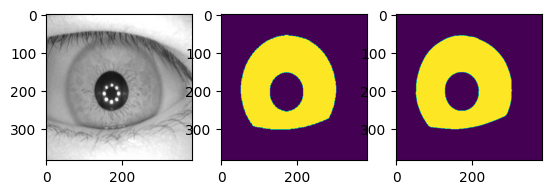

In [15]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())